In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn import preprocessing, metrics

from sklearn.model_selection import KFold

In [4]:
X = pd.read_csv('../data/molorg_features.csv',header = 0)
# remove constant columns (check previous notebook)
X = X.loc[:, (X != X.iloc[0]).any()]
# select a smaller number of features
X = X.iloc[:,0:50]
print X.shape

(1000, 50)


In [5]:
y = pd.read_csv('../data/molorg_pol.csv', header = 0)
print y.shape

(1000, 1)


## Train-Test Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train.shape, X_test.shape

((900, 50), (100, 50))

In [15]:
scaler = preprocessing.StandardScaler()
Xtr = scaler.fit_transform(X_train)
Xte = scaler.transform(X_test)
ytr = scaler.fit_transform(y_train)

mlp = MLPRegressor(hidden_layer_sizes = (20,10), activation= 'relu', alpha = 1, early_stopping=True)
mlp.fit(Xtr, ytr)

MLPRegressor(activation='relu', alpha=1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(20, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [20]:
# metrics
yte_pred = mlp.predict(Xte)
yte_pred = scaler.inverse_transform(yte_pred)
print 'MAE (Bohr3):', metrics.mean_absolute_error(y_test, yte_pred)
y.describe()

MAE (Bohr3): 8.92934322113


,pol_Bohr3
count,1000.000000
mean,231.290682
std,45.319700
min,104.482400
25%,200.431300
50%,230.786600
75%,268.655100
max,337.230200


## Kfold Cross-validation and model selection

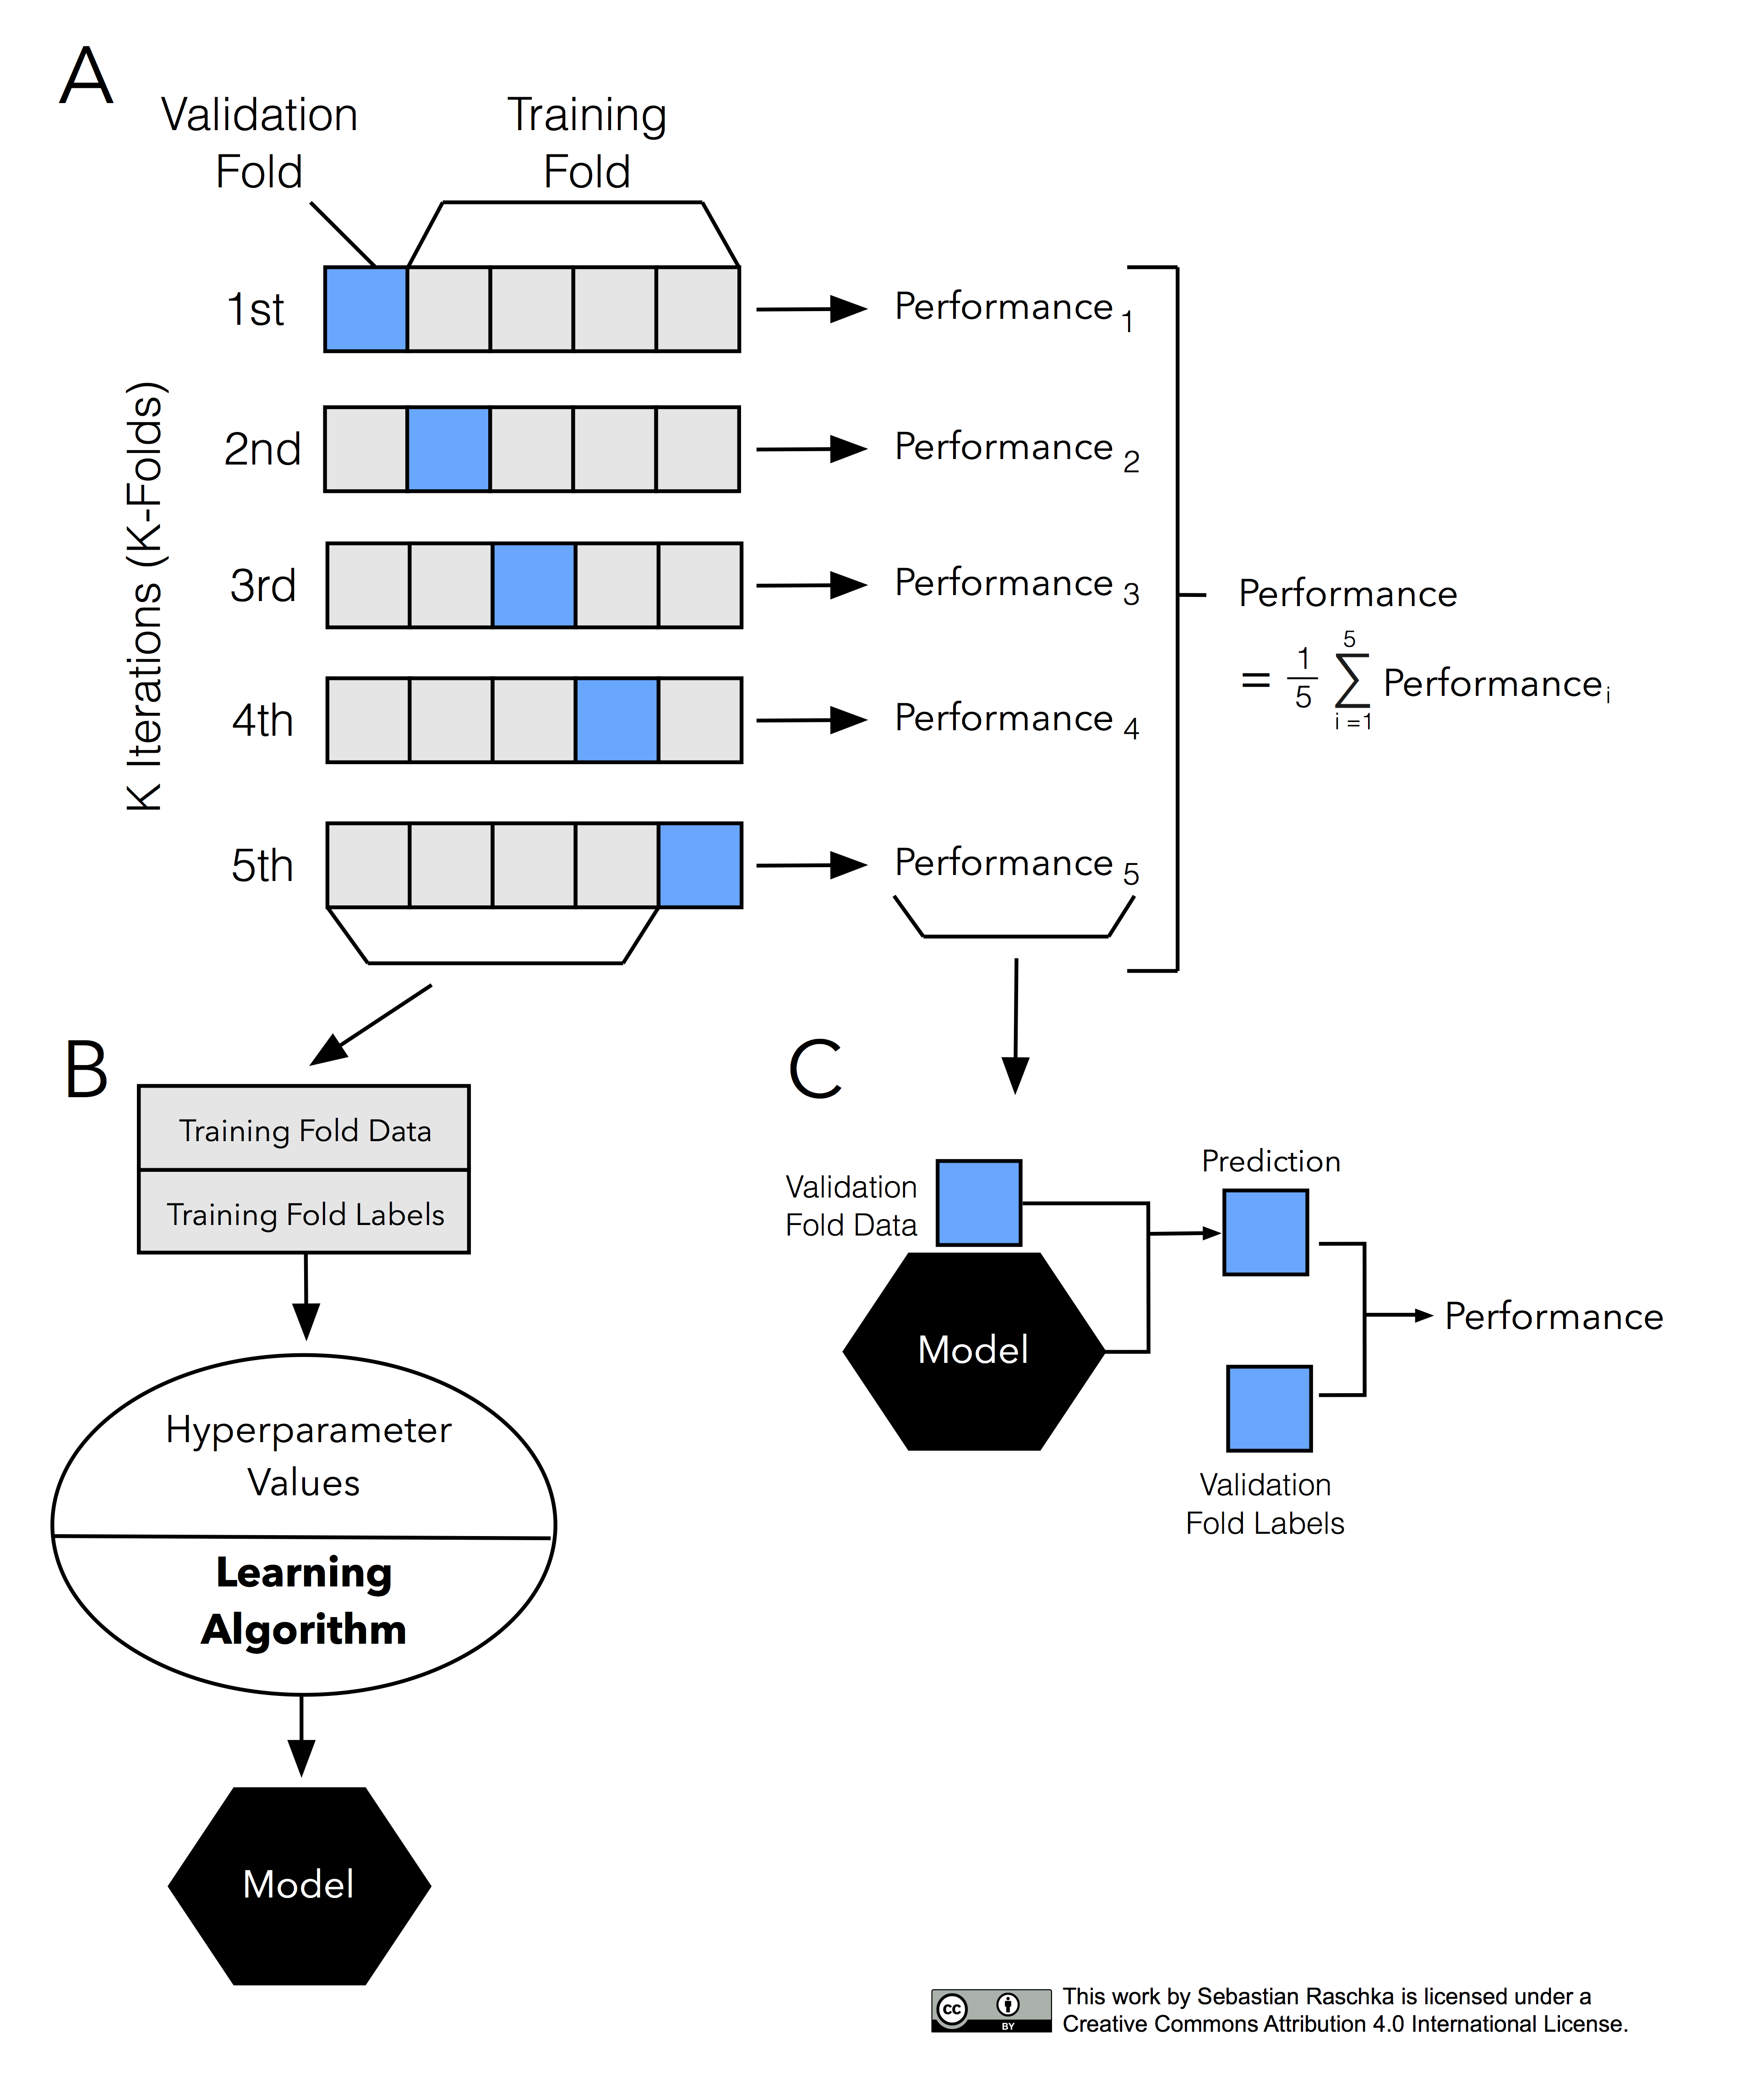

In [1]:
from IPython.core.display import Image, display
display(Image(filename='images/Kfold.png'))

https://sebastianraschka.com/blog/2016/model-evaluation-selection-part3.html


## implementation of grid search
Note: make sure you always have an independent test set for your final model. 

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values.reshape(-1,1), test_size=0.1, random_state=0)
X_train.shape, X_test.shape

kf = KFold(n_splits=3, random_state=7)
alpha_grid = [10, 3, 1, .3, .1, .03, .01]
for alpha in alpha_grid:
    cv_results = []
    for train_index, test_index in kf.split(X_train):
        Xtr = X_train[train_index]
        Xte = X_train[test_index]
        ytr = y_train[train_index]
        yte = y_train[test_index]
        
        scaler = preprocessing.StandardScaler()
        Xtr = scaler.fit_transform(Xtr)
        Xte = scaler.transform(Xte)
        ytr = scaler.fit_transform(ytr)

        mlp = MLPRegressor(hidden_layer_sizes = (20,10), activation= 'relu', alpha = alpha, early_stopping=True)
        mlp.fit(Xtr, ytr)
        ytr_pred = mlp.predict(Xtr)
        ytr_pred = scaler.inverse_transform(ytr_pred)
        ytr = scaler.inverse_transform(ytr)
        yte_pred = mlp.predict(Xte)
        yte_pred = scaler.inverse_transform(yte_pred)
        l = []
        l.append(metrics.mean_absolute_error(ytr, ytr_pred))
        l.append(metrics.mean_absolute_error(yte, yte_pred))
        cv_results.append(l)
    print 'alpha:', alpha, ' ===> (MAE train, MAE test):', np.mean(np.array(cv_results), axis = 0) 



alpha: 10  ===> (MAE train, MAE test): [ 8.41434748  8.91032958]
alpha: 3  ===> (MAE train, MAE test): [ 8.3623481   9.51976569]
alpha: 1  ===> (MAE train, MAE test): [ 8.02436413  8.87050031]
alpha: 0.3  ===> (MAE train, MAE test): [  9.25815839  10.17415816]
alpha: 0.1  ===> (MAE train, MAE test): [ 8.81568065  9.33244225]
alpha: 0.03  ===> (MAE train, MAE test): [ 8.1772655  9.1447438]
alpha: 0.01  ===> (MAE train, MAE test): [ 8.71729283  9.61398757]


## scikit-learn: cross validated grid search 

In [11]:
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values.reshape(-1,1), test_size=0.1, random_state=0)
scaler = preprocessing.StandardScaler()
Xtr = scaler.fit_transform(X_train)
ytr = scaler.fit_transform(y_train)



alpha_grid = [10, 3, 1, .3, .1, .03, .01]
mlp = MLPRegressor(hidden_layer_sizes = (20,10), activation= 'relu', early_stopping=True)
scorer = metrics.make_scorer(score_func = metrics.mean_absolute_error,
                            greater_is_better = False)
kf = KFold(n_splits=3, random_state=7)

gs = GridSearchCV(estimator = mlp, 
                  param_grid = {'alpha':alpha_grid},
                  scoring = scorer,
                  cv = kf)
gs.fit(Xtr, ytr)
pd.DataFrame(gs.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.417453,0.000743,-0.204435,-0.193892,10,{u'alpha': 10},2,-0.203931,-0.194947,-0.183330,-0.187293,-0.226045,-0.199437,0.052782,0.000030,0.017442,0.005014
1,0.255447,0.000727,-0.262375,-0.257980,3,{u'alpha': 3},7,-0.211026,-0.199764,-0.326476,-0.337585,-0.249621,-0.236592,0.229752,0.000047,0.047987,0.058263
2,0.257202,0.000724,-0.199569,-0.185275,1,{u'alpha': 1},1,-0.192934,-0.173259,-0.189279,-0.191989,-0.216494,-0.190576,0.047804,0.000031,0.012060,0.008516
3,0.251736,0.001043,-0.217072,-0.198175,0.3,{u'alpha': 0.3},5,-0.213215,-0.188294,-0.199928,-0.183563,-0.238073,-0.222669,0.087419,0.000491,0.015810,0.017427
4,0.231563,0.000700,-0.210388,-0.184022,0.1,{u'alpha': 0.1},3,-0.200432,-0.178954,-0.199014,-0.181354,-0.231720,-0.191758,0.044782,0.000004,0.015095,0.005557
5,0.293460,0.000720,-0.231091,-0.216823,0.03,{u'alpha': 0.03},6,-0.286957,-0.290213,-0.193157,-0.178455,-0.213160,-0.181801,0.197296,0.000018,0.040338,0.051913
6,0.174480,0.000705,-0.212748,-0.194055,0.01,{u'alpha': 0.01},4,-0.213931,-0.185189,-0.212359,-0.208871,-0.211954,-0.188104,0.037142,0.000004,0.000852,0.010544


## scikit-learn: cross validated randomized search 

In [20]:
from sklearn.model_selection import RandomizedSearchCV

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values.reshape(-1,1), test_size=0.1, random_state=0)
scaler = preprocessing.StandardScaler()
Xtr = scaler.fit_transform(X_train)
ytr = scaler.fit_transform(y_train)


alpha_dist = np.random.normal(2,1,100)
mlp = MLPRegressor(hidden_layer_sizes = (20,10), activation= 'relu', early_stopping=True)
scorer = metrics.make_scorer(score_func = metrics.mean_absolute_error,
                            greater_is_better = False)
kf = KFold(n_splits=3, random_state=7)

rs = RandomizedSearchCV(estimator = mlp, 
                          param_distributions = {'alpha':alpha_dist},
                          n_iter= 10,
                          scoring = scorer,
                          cv = kf)
rs.fit(Xtr, ytr)
pd.DataFrame(rs.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.430086,0.000748,-0.197213,-0.184060,2.18907,{u'alpha': 2.18907423428},3,-0.188025,-0.179000,-0.201839,-0.197526,-0.201776,-0.175654,0.071463,0.000068,0.006497,0.009620
1,0.282997,0.000703,-0.201904,-0.179320,1.28876,{u'alpha': 1.28875540178},5,-0.201783,-0.172879,-0.187947,-0.180406,-0.215982,-0.184675,0.031610,0.000007,0.011446,0.004877
2,0.217706,0.000707,-0.223063,-0.213497,1.54611,{u'alpha': 1.54610758915},10,-0.270441,-0.273735,-0.182641,-0.185077,-0.216108,-0.181680,0.135862,0.000017,0.036180,0.042617
3,0.224520,0.000701,-0.210869,-0.201066,0.788611,{u'alpha': 0.788611403446},7,-0.217502,-0.204134,-0.209744,-0.211942,-0.205362,-0.187122,0.040160,0.000006,0.005019,0.010362
4,0.221577,0.000740,-0.214261,-0.196714,0.562458,{u'alpha': 0.562457821331},8,-0.208744,-0.186568,-0.211817,-0.205805,-0.222221,-0.197769,0.087339,0.000056,0.005767,0.007889
5,0.365197,0.000811,-0.196353,-0.184914,2.16312,{u'alpha': 2.16311908816},2,-0.185490,-0.170138,-0.175388,-0.178968,-0.228182,-0.205635,0.121112,0.000159,0.022881,0.015089
6,0.309346,0.000697,-0.208167,-0.187496,3.4598,{u'alpha': 3.45980439035},6,-0.198611,-0.173260,-0.213909,-0.199302,-0.211981,-0.189926,0.017497,0.000004,0.006803,0.010770
7,0.406302,0.000783,-0.197400,-0.182531,2.31973,{u'alpha': 2.31972590997},4,-0.211349,-0.195171,-0.186356,-0.177767,-0.194495,-0.174653,0.077353,0.000056,0.010408,0.009028
8,0.375245,0.000723,-0.195977,-0.180249,2.04912,{u'alpha': 2.04912122001},1,-0.198715,-0.182434,-0.172522,-0.174568,-0.216693,-0.183745,0.134903,0.000036,0.018136,0.004053
9,0.239591,0.000696,-0.219462,-0.212869,4.02259,{u'alpha': 4.0225887723},9,-0.202856,-0.180380,-0.173903,-0.175295,-0.281628,-0.282931,0.145352,0.000003,0.045519,0.049585
